In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.metrics import auc
import pickle
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


# 1. Load data & preprocessing

## 1.1 Encoding for Categorical Feature
- label encoding: deal with categorical features;
    - one hot encoding: 生成更多特征
- pick the features as X and the target as y;
- split the data into training and testing sets; (选择前六个月0-5作为训练集，这是作者提到的一个实践方式）
- scale the numerical features(MinMaxScaler);由于大量特征的分布并不趋于正态，有大量异常值等，选择minmax更好
- store the indices of the categorical features(for later use in SMOTE-NC);

In [3]:
base=pd.read_csv('./datasets/processed_base.csv')
base.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,velocity_6h,velocity_24h,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.3,0.986506,25.0,40,0.006735,AA,1059,13096.035018,7850.955007,...,9.0,0,1500.0,0,INTERNET,16.224843,linux,1,1.0,0
1,0,0.8,0.617426,89.0,20,0.010095,AD,1658,9223.283431,5745.251481,...,2.0,0,1500.0,0,INTERNET,3.363854,other,1,1.0,0
2,0,0.8,0.996707,14.0,40,0.012316,AB,1095,4471.472149,5471.988958,...,30.0,0,200.0,0,INTERNET,22.730559,windows,0,1.0,0
3,0,0.6,0.475100,14.0,30,0.006991,AB,3483,14431.993621,6755.344479,...,1.0,0,200.0,0,INTERNET,15.215816,linux,1,1.0,0
4,0,0.9,0.842307,29.0,40,5.742626,AA,2339,7601.511579,5124.046930,...,26.0,0,200.0,0,INTERNET,3.743048,other,0,1.0,0


In [4]:
# labnel encoding
def label_encoding(data):
    # 需要进行Label Encoding的分类变量
    categorical_features = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
    
    # 创建 LabelEncoder 实例
    label_encoder = LabelEncoder()
    
    # 对每个分类变量进行 Label Encoding
    for feature in categorical_features:
        data[feature] = label_encoder.fit_transform(data[feature])
    
    return data

# one-hot encoding
def one_hot_encoding(data):
    # 需要进行One-Hot Encoding的分类变量
    categorical_features = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
    
    # 使用pd.get_dummies进行One-Hot Encoding
    # drop_first=True表示删除第一个类别，避免多重共线性,同时避免引入不必要的特征并且保留了所有信息
    # 此时先用False保留所有特征，后续建立模型时候可以选择drop_first=True来避免多重共线性并减少特征数量
    data_encoded = pd.get_dummies(data, columns=categorical_features,drop_first=True)
    
    # 找出新生成的 One-Hot 编码列
    encoded_columns = data_encoded.columns.difference(data.columns)
    
    # 将 One-Hot 编码列转换为整数类型
    data_encoded[encoded_columns] = data_encoded[encoded_columns].astype(int)
    
    return data_encoded

# 示例预处理
df = one_hot_encoding(base)
df.head()

# df = label_encoding(base)
# df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,25.0,40,0.006735,1059,13096.035018,7850.955007,6742.080561,...,1,0,0,0,0,0,0,0,0,0
1,0,0.8,0.617426,89.0,20,0.010095,1658,9223.283431,5745.251481,5941.664859,...,1,0,0,0,0,0,0,1,0,0
2,0,0.8,0.996707,14.0,40,0.012316,1095,4471.472149,5471.988958,5992.555113,...,1,0,0,0,0,0,0,0,1,0
3,0,0.6,0.475100,14.0,30,0.006991,3483,14431.993621,6755.344479,5970.336831,...,1,0,0,0,0,0,0,0,0,0
4,0,0.9,0.842307,29.0,40,5.742626,2339,7601.511579,5124.046930,5940.734212,...,1,0,0,0,0,0,0,1,0,0


## 1.2 Undersampling

NearMiss和RandomUnderSampler是两种常见的欠采样（undersampling）方法，用于处理不平衡数据集中的类别不平衡问题。它们的主要区别如下：

### 1. NearMiss

NearMiss是一种基于距离的欠采样方法。它有几种变体（例如NearMiss-1，NearMiss-2，NearMiss-3），其主要思想是通过选择与多数类样本最接近的少数类样本来进行欠采样。具体来说：

- **NearMiss-1**：选择离最近的少数类样本最近的多数类样本。这种方法倾向于选择与少数类样本最近的多数类样本，保持少数类样本周围的多数类样本。
- **NearMiss-2**：选择离最远的少数类样本最近的多数类样本。这种方法倾向于选择那些与少数类样本距离最远的多数类样本，确保选择的多数类样本分布在少数类样本周围。
- **NearMiss-3**：根据少数类样本的平均距离来选择多数类样本。这种方法综合了前两种方法的特点，选择那些在少数类样本的平均距离范围内的多数类样本。

### 2. RandomUnderSampler

RandomUnderSampler是一种简单的随机欠采样方法。它通过随机选择多数类样本来减少其数量，从而平衡数据集中的类分布。这种方法不考虑样本之间的距离或其他特征，仅仅是随机选择一定数量的多数类样本进行移除。

### 区别总结

- **选择策略**：
  - NearMiss：基于样本之间的距离选择多数类样本，有多种变体。
  - RandomUnderSampler：随机选择多数类样本，没有考虑样本特征或距离。
  
- **复杂度**：
  - NearMiss：计算复杂度较高，需要计算样本之间的距离。
  - RandomUnderSampler：计算复杂度低，直接随机选择样本。

- **适用场景**：
  - NearMiss：适用于需要考虑样本之间关系的场景，可以帮助保留数据结构。
  - RandomUnderSampler：适用于快速简单的欠采样需求，不考虑样本间关系。

### 3. IHT
Instance Hardness Threshold (IHT) 是一种基于样本难度的下采样方法，它通过移除那些易于分类的多数类样本，只保留那些难以分类的样本，从而减少样本数量。IHT算法通常通过以下步骤实现：

计算样本难度：使用分类器对每个样本进行预测，得到每个样本被正确分类的概率。难度较高的样本被赋予较低的概率。
选择样本：根据难度阈值，选择那些难度较高（即预测概率较低）的多数类样本进行保留。


In [32]:
# 下采样函数
def undersample_majority_class(x, y, ratio=10, strategy='nearmiss'):
    minority_class_size = np.sum(y == 1)
    majority_class_size = minority_class_size * ratio
    
    if strategy == 'random':
        undersample = RandomUnderSampler(sampling_strategy={0: majority_class_size, 1: minority_class_size}, random_state=42)
    elif strategy == 'nearmiss':
        undersample = NearMiss(sampling_strategy=1/ratio, n_jobs=-1)
    elif strategy == 'iht':
        # clf = RandomForestClassifier(random_state=42,n_jobs=-1)
        # clf = XGBClassifier(n_jobs=-1, random_state=42)
        # clf = LGBMClassifier(n_jobs=-1, random_state=42)
        clf = DecisionTreeClassifier(random_state=42)
        undersample = InstanceHardnessThreshold(estimator=clf, sampling_strategy=0.1,n_jobs=-1)  
    else:
        raise ValueError("Unsupported strategy. Use 'random', 'nearmiss', or 'iht'.")
    
    x_resampled, y_resampled = undersample.fit_resample(x, y)
    return x_resampled, y_resampled

In [33]:
# train test split
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

X_nm, y_nm = undersample_majority_class(X, y, ratio=10, strategy='iht')
y.value_counts(),y_nm.value_counts()

(fraud_bool
 0    982612
 1     10995
 Name: count, dtype: int64,
 fraud_bool
 0    969948
 1     10995
 Name: count, dtype: int64)

## 1.3 Split the data & Scaling
使用Minmax scaling，因为数据分布不符合正态分布，且存在大量异常值。

In [21]:
# split
x_train, x_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.2, random_state=42, shuffle=True)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(Counter(y_train),Counter(y_test))
# 筛选出二进制特征
binary_features_name = [
    'email_is_free',
    'phone_home_valid',
    'phone_mobile_valid',
    'has_other_cards',
    'foreign_request',
    'keep_alive_session',
    'fraud_bool'
]

binary_features = df[binary_features_name]

# 列出所有的数值型特征
# numeric_features_name = df.select_dtypes(include=['number']).columns.tolist()
# 去掉二进制特征
# numeric_features_name = [col for col in numeric_features_name if col not in binary_features_name]

numeric_features_name=[x for x in df.columns if df[x].nunique() >= 10]

numeric_features = df[numeric_features_name]

# 创建 MinMaxScaler 实例
numeric_transformer = MinMaxScaler()

# 创建 ColumnTransformer
preprocessor = ColumnTransformer([('scaled', numeric_transformer, numeric_features_name)], remainder='passthrough')

# 在训练集上拟合并转换
x_train_scaled = preprocessor.fit_transform(x_train)

# 仅转换测试集
x_test_scaled = preprocessor.transform(x_test)

# 获取列的顺序(colmuntransformer会改变列的顺序)
new_columns = numeric_features_name + [col for col in x_train.columns if col not in numeric_features_name]

# 转换后的结果通常为 NumPy 数组，将其转换回 DataFrame 并保持列名一致性
x_train_scaled = pd.DataFrame(x_train_scaled, columns=new_columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=new_columns)

# 确定分类特征的名称
categorical_features_name = [col for col in x_train_scaled.columns if 2 <= x_train_scaled[col].nunique() < 10]

# 确定分类特征的索引
all_features = list(x_train_scaled.columns)  # 所有特征的名称列表
categorical_feature_indices = [i for i, feature in enumerate(all_features) if feature in categorical_features_name]

print("分类特征名称：", categorical_features_name)
print("分类特征索引：", categorical_feature_indices)

Counter({0: 87895, 1: 8861}) Counter({0: 22055, 1: 2134})
分类特征名称： ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_TELEAPP', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11']
分类特征索引： [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


# 2. Modeling
## 2.1 Training Function
当resample first 为 True则直接过采样然后交叉验证；

否则会每次交叉验证都过采样来保证数据不泄露。

In [8]:
def train_classifier(classifier, param_dist, X_train, y_train, encoded_features, search_type='random', scoring='roc_auc', iterations=10):
    
    # 转换为numpy数组并确保数据类型高效
    X_train = np.array(X_train).astype(np.float32)
    y_train = np.array(y_train).astype(np.int32)
    
    # 创建交叉验证策略
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 选择评分方法
    if scoring == 'f1':
        scoring_method = make_scorer(f1_score, pos_label=1)  # pos_label=1 表示正类标签为1
    elif scoring == 'recall':
        scoring_method = make_scorer(recall_score, pos_label=1)
    else:
        scoring_method = scoring

    # 构建采样和模型管道
    smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42, n_jobs=-1)
    
    pipeline = make_pipeline(smote_nc, classifier)
    
    # 进行超参数搜索
    if search_type == 'random':
        search_cv = RandomizedSearchCV(estimator=pipeline, 
                                       param_distributions=param_dist,
                                       n_iter=iterations,
                                       scoring=scoring_method,
                                       n_jobs=-1,
                                       cv=cv,
                                       verbose=2)
    elif search_type == 'grid':
        search_cv = GridSearchCV(estimator=pipeline,
                                 param_grid=param_dist,
                                 scoring=scoring_method,
                                 n_jobs=-1,
                                 cv=cv,
                                 verbose=2)
    else:
        raise ValueError('search_type 必须是 "random" 或 "grid"')
        
    # 拟合模型并返回训练好的分类器
    search_cv.fit(X_train, y_train)

    return search_cv

## 2.2 Evaluate Function
主要两个评估指标：
- 5% FPR阈值下的recall
- predictive equality

In [22]:
# print classification report
def print_cls_report(y_test, y_pred, title="Classification Report"):
    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report["1"]["recall"]
    print(f"{title}:\n", classification_report(y_test, y_pred))
    return recall

# print cv results
def print_cv_results(model):
    # Get the parameter and score arrays from the cv_results_ dictionary
    means = model.cv_results_['mean_test_score']
    params = model.cv_results_['params']

    # Combine the arrays using zip()
    combined_results = zip(means, params)

    # Sort the combined array by mean_test_score in descending order
    sorted_results = sorted(combined_results, key=lambda x: x[0], reverse=True)

    # Print the mean test score and the hyperparameters as a formatted string
    for mean, param in sorted_results:
        print("mean_test_score: %f, params: %r" % (mean, param))

# plot roc curve
def plot_roc_curves(fpr_list, tpr_list, label_list):
    plt.figure(figsize=(8, 8))
    for i in range(len(fpr_list)):
        # Compute the ROC AUC score
        roc_auc_score = auc(fpr_list[i], tpr_list[i])
        # Plot the ROC curve
        plt.plot(fpr_list[i], tpr_list[i], label=f'{label_list[i]} (AUC={roc_auc_score:.2f})')
    
    # Plot the random classifier curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Set the plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# my_palette = sns.color_palette("husl", 2)

# plot confusion matrix
def plot_con_matrix(ax, y_test, y_pred, title):
    # Define the classes of the classification problem
    classes = ['No Fraud', 'Fraud']

    # Compute the confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)

    # Compute the values for true negatives, false positives, false negatives, and true positives
    tn, fp, fn, tp = con_matrix.ravel()

    # Compute the false positive rate
    fpr = fp / (fp + tn)

    # Plot the confusion matrix using a heatmap
    # ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.GnBu,alpha=0.7)
    
    # Define the tick marks and the labels for the plot
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Add the count of each cell of the confusion matrix to the plot
    fmt = 'd'
    threshold = con_matrix.max() / 2.
    for i, j in np.ndindex(con_matrix.shape):
        ax.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > threshold else "black")

    # Add labels to the plot
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{title} with {fpr*100:.2f}% FPR')

In [29]:
# labels = y_test
groups = (x_test["customer_age"] > 50).map({True: ">50", False: "<=50"}) 

# Define a function to calculate fairness metrics
def get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
    predictive_equality = disparities_df["fpr"].min() / (disparities_df["fpr"].max()+0.00001)
    return predictive_equality, disparities_df

# Evaluate Function
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test, groups):
    y_train_pred = classifier.predict(x_train)
    y_pred = classifier.predict(x_test)
    y_prob = classifier.predict_proba(x_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    target_fpr = 0.05  # Set the target threshold at 5% FPR
    threshold_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[threshold_idx]
    
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    train_set = print_cls_report(y_train, y_train_pred, title="Train Set")
    default_recall = print_cls_report(y_test, y_pred, title="Default Threshold")
    target_recall = print_cls_report(y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')
    
    default_predictive_equality, default_disparities_df = get_fairness_metrics(y_test, y_pred, groups, 0.5)
    target_predictive_equality, target_disparities_df = get_fairness_metrics(y_test, y_pred_threshold, groups, target_fpr)
    
    print(f"Default Predictive Equality: {default_predictive_equality:.2f}")
    print(f"Target Predictive Equality: {target_predictive_equality:.2f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    default_matrix = plot_con_matrix(ax1, y_test, y_pred, title='Default Threshold @ 0.50')
    target_matrix = plot_con_matrix(ax2, y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    plt.tight_layout()
    plt.show()

    return fpr, tpr, default_recall, target_recall, default_predictive_equality, target_predictive_equality


## 2.3 Running the Model
### 2.3.1 RandomForest

In [24]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Define a dictionary of hyperparameters for RandomForestClassifier
rf_params = {'randomforestclassifier__n_estimators': [ 60, 80, 100,120],
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
            'randomforestclassifier__max_features': ['sqrt', 'log2']
            }
# 使用imblearn的Pipeline时命名方式区别于make_pipe
# rf_params = {
#     'classifier__n_estimators': [60, 80, 100, 120],
#     'classifier__criterion': ['gini', 'entropy'],
#     'classifier__max_depth': [2, 4, 6, 8, 10],
#     'classifier__max_features': ['sqrt', 'log2']
# }

rf_model = train_classifier(rf, rf_params, x_train_scaled, y_train, categorical_feature_indices, search_type='random',scoring='f1',iterations=20)

print('best params for rf:',rf_model.best_params_,'\n')

print(print_cv_results(rf_model))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


E:\Programming\anaconda3\envs\mytorch\lib\site-packages\imblearn\over_sampling\_smote\base.py:645: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


best params for rf: {'randomforestclassifier__n_estimators': 120, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini'} 

mean_test_score: 0.957470, params: {'randomforestclassifier__n_estimators': 120, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini'}
mean_test_score: 0.956103, params: {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy'}
mean_test_score: 0.951945, params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'gini'}
mean_test_score: 0.951131, params: {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier_

In [28]:
# 假设 rf_model 是你的训练好的模型
with open('./saved_models/rf_iht.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
    
print("Model saved successfully!")

Model saved successfully!


E:\Programming\anaconda3\envs\mytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
E:\Programming\anaconda3\envs\mytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
E:\Programming\anaconda3\envs\mytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Train Set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     87895
           1       1.00      0.94      0.97      8861

    accuracy                           0.99     96756
   macro avg       1.00      0.97      0.98     96756
weighted avg       0.99      0.99      0.99     96756

Default Threshold:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     22055
           1       1.00      0.92      0.96      2134

    accuracy                           0.99     24189
   macro avg       1.00      0.96      0.98     24189
weighted avg       0.99      0.99      0.99     24189

Target Threshold @ 0.15:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22055
           1       0.67      0.99      0.80      2134

    accuracy                           0.96     24189
   macro avg       0.83      0.97      0.89     24189
weighted avg    

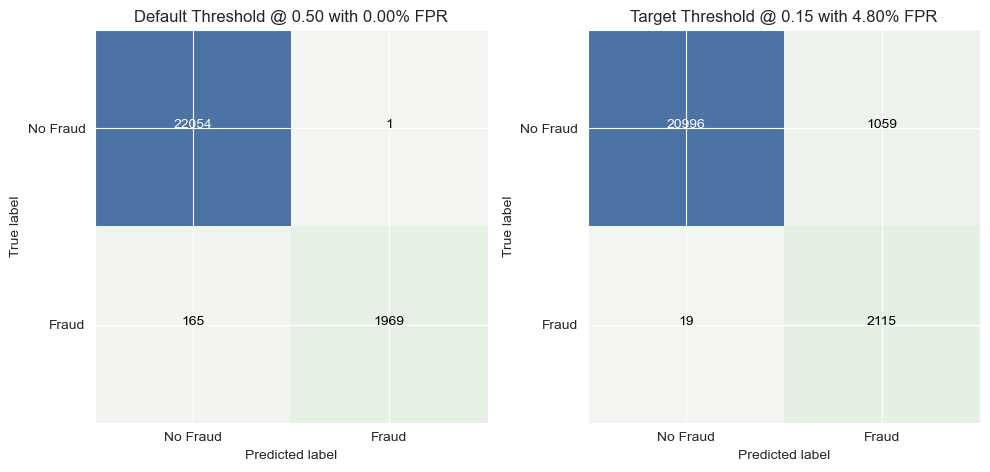

ValueError: too many values to unpack (expected 4)

In [25]:
rf_fpr,rf_tpr,rf_default_recall,rf_target_recall=evaluate_classifier(rf_model,x_train_scaled,y_train,x_test_scaled,y_test,groups)

### 2.3.2 XGBoost

In [13]:
from xgboost import XGBClassifier

# Instantiate a XGBClassifier model with GPU acceleration for training
xgb = XGBClassifier(n_jobs=-1, random_state=42)

# Define a dictionary of hyperparameters for XGBClassifier
xgb_params = {'xgbclassifier__n_estimators': [20, 60, 100, 150],
              'xgbclassifier__max_depth': [2, 4, 6, 8],
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.20],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4],
              'xgbclassifier__subsample': [0.6, 0.8, 1.0],
              'xgbclassifier__colsample_bytree': [0.4,0.6, 0.8, 1.0]
             }

xgb_model = train_classifier(xgb, xgb_params, x_train_scaled, y_train, categorical_feature_indices, search_type='random', scoring='f1',iterations=20)

print('best params for xgb:',xgb_model.best_params_,'\n')

print(print_cv_results(xgb_model))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


E:\Programming\anaconda3\envs\mytorch\lib\site-packages\imblearn\over_sampling\_smote\base.py:645: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


best params for xgb: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 0.4} 

mean_test_score: 0.971984, params: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 0.4}
mean_test_score: 0.971065, params: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 0.8}
mean_test_score: 0.970646, params: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 1.0}
mean_tes

In [26]:
# 假设 xgb_model 是你的训练好的模型
with open('./saved_models/xgb_iht.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("Model saved successfully!")

# # Load the saved model
# with open('xgb_iht.pkl', 'rb') as file:
#     xgb_model = pickle.load(file)
#     
# print("Model loaded successfully!")

Model saved successfully!


Train Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87952
           1       1.00      0.97      0.98      8812

    accuracy                           1.00     96764
   macro avg       1.00      0.98      0.99     96764
weighted avg       1.00      1.00      1.00     96764

Default Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22008
           1       0.99      0.96      0.97      2183

    accuracy                           1.00     24191
   macro avg       0.99      0.98      0.99     24191
weighted avg       1.00      1.00      1.00     24191

Target Threshold @ 0.04:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22008
           1       0.66      0.99      0.79      2183

    accuracy                           0.95     24191
   macro avg       0.83      0.97      0.88     24191
weighted avg    

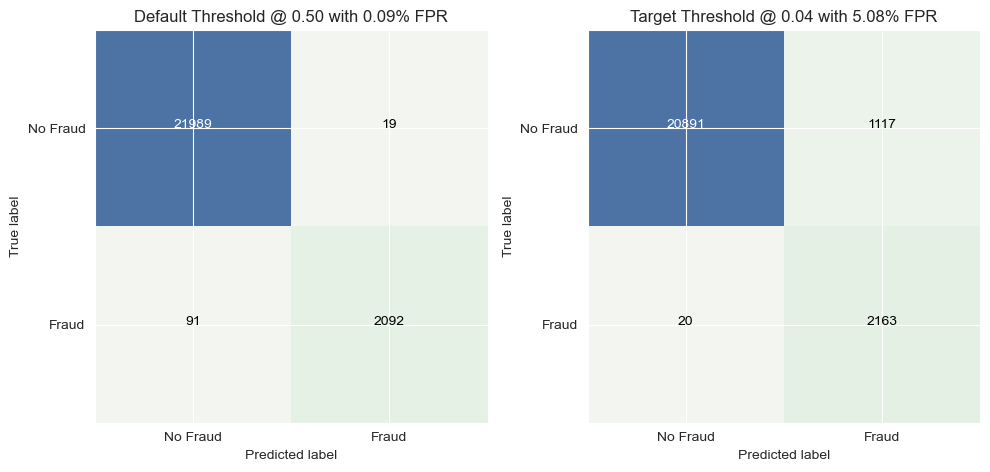

ValueError: too many values to unpack (expected 4)

In [14]:
# Testing the XGBoost model using the test data and calculating metrics
xgb_fpr, xgb_tpr, xgb_default_recall, xgb_target_recall = evaluate_classifier(xgb_model, x_train_scaled, y_train, x_test_scaled, y_test, groups)

### 2.3.3 LightGBM

- [LightGBM] [Info] Total Bins 3398
表示所有特征的总bin数（区间数）。LightGBM在内部会将连续特征离散化成多个bin，这里总共使用了3398个bin。
- [LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008127 seconds.
LightGBM自动选择了行方向多线程处理，测试开销为0.008127秒。LightGBM可以选择按行或按列进行多线程处理。行方向多线程处理通常适用于大多数情况。可以选择列方向多线程处理，但是在某些情况下可能会导致性能下降，但是能减少内存占用情况。

In [26]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_jobs=-1, random_state=42)

# Define a dictionary of hyperparameters for LGBMClassifier
lgb_params = {'lgbmclassifier__max_depth': [2, 4, 6, 8, 10], # 最大深度
               'lgbmclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20], # 学习率
               'lgbmclassifier__n_estimators': [60, 80, 100, 140], # 迭代次数
               'lgbmclassifier__min_child_weight': [1, 2, 3, 4], # 最小叶子节点样本权重和
               'lgbmclassifier__subsample': [0.6, 0.8, 1.0], # 用于训练模型的子样本占整个样本集合的比例
               'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0] # 在建立树时对特征随机采样的比例
              }

lgb_model = train_classifier(lgb, lgb_params, x_train_scaled, y_train, categorical_feature_indices, search_type='random', scoring='f1',iterations=20)

print('\nbest params for lgb:',lgb_model.best_params_,'\n')

print(print_cv_results(lgb_model))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


E:\Programming\anaconda3\envs\mytorch\lib\site-packages\imblearn\over_sampling\_smote\base.py:645: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 87895, number of negative: 87895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 175790, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

best params for lgb: {'lgbmclassifier__subsample': 0.6, 'lgbmclassifier__n_estimators': 140, 'lgbmclassifier__min_child_weight': 1, 'lgbmclassifier__max_depth': 8, 'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__colsample_bytree': 1.0} 

mean_test_score: 0.986212, params: {'lgbmclassifier__subsample': 0.6, 'lgbmclassifier__n_estimators'

Train Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87895
           1       1.00      1.00      1.00      8861

    accuracy                           1.00     96756
   macro avg       1.00      1.00      1.00     96756
weighted avg       1.00      1.00      1.00     96756

Default Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22055
           1       1.00      0.98      0.99      2134

    accuracy                           1.00     24189
   macro avg       1.00      0.99      0.99     24189
weighted avg       1.00      1.00      1.00     24189

Target Threshold @ 0.00:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22055
           1       0.65      1.00      0.79      2134

    accuracy                           0.95     24189
   macro avg       0.83      0.97      0.88     24189
weighted avg    

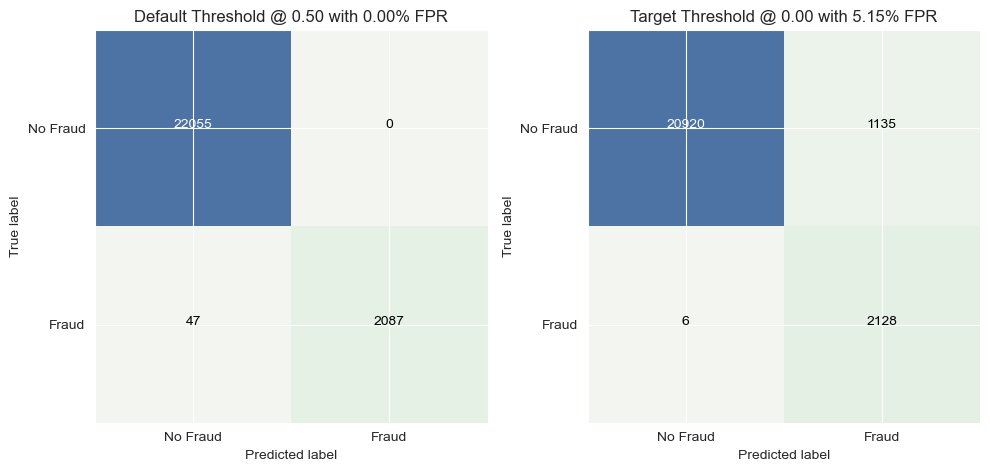

ValueError: too many values to unpack (expected 4)

In [30]:
lgb_fpr, lgb_tpr, lgb_default_recall, lgb_target_recall = evaluate_classifier(lgb_model, x_train_scaled, y_train, x_test_scaled, y_test, groups)